# La théorie du bien-être social

Le problème présenté ici rentre dans le cadre de l'affectation de ressources à un certain nombre d'agents. On a un ensemble de ressources et un ensemble d'agents à qui l'on doit distribuer ces ressources. Chaque agent étant autonome, il n'accorde pas la même importance aux différentes ressources que ses congénères. Pour mesurer la satisfaction d'un agent lors de la possession d'un certain nombre de ressources on utilise ici une fonction d'utilité qui, pour chaque ressource, indique la valeur que l'agent lui accorde. D'autres considérations pourraient être prises en compte, nous restons dans un cadre simple. Quand les utilités sont additives, ce qui sera le cas ici, le bien-être individuel d'un agent est alors la somme des utilités qu'il accorde aux ressources qu'il possède.
Mais la collectivité doit aussi s'accorder sur une mesure de bien-être. Pour mesurer le bien-être social, il existe 5 grandes méthodes:

- Utilitaire : maximiser la somme des utilités de chaque agent
- Egalitaire : maximiser le minimum
- Elitiste : maximiser le maximum
- ressource de Nash : maximiser le ressource
- Leximin : maximiser dans l'ordre lexicographique les vecteurs des utilités de chaque agent classées du min au max

Le problème consiste alors à trouver comment affecter l'ensemble des ressources aux différents agents de manière à maximiser le bien-être social choisi.

Cette feuille montre comment, à l'aide d'une approche comportementale, il est possible de s'approcher voire de calculer l'optimum social.

### Comment coder ressources et fonctions d'utilité

Afin de pouvoir jouer sur les nombres de ressources et/ou d'agents, nous générerons aléatoirement des noms de ressources afin de pouvoir en avoir autant que l'on souhaite.  Pour la fonction d'utilité, on utilisera un dictionnaire Python, donc les clés sont les articles potentiels et les valeurs le poids que l'agent accorde à cette clé. Pour ces valeurs on prendra un entier naturel (donc sans le zero). Par convention, plus il sera important, plus l'agent accordera de la valeur à cet article.


In [2]:
import random
import string
import functools
import numpy as np

nb=10                        # nb de ressources souhaités
valeurs = list(range(1,20))  # intervalle de valuation de chaque ressource

def genere_nom():
    return ''.join(random.choice(string.ascii_uppercase) for _ in range(5))
   
# Generer une liste de ressources
ressources = [genere_nom() for _ in range(nb)]
print("Un ensemble de ressources \t", ressources)

# Creer une fonction d'utilité avec des valeurs aléatoires
u = {r : random.choice(valeurs) for r in ressources}
print("Une fonction d'utilité\t" , u)

Un ensemble de ressources 	 ['WNJDL', 'KEILX', 'SWJUQ', 'YEIQA', 'XMEHE', 'GRLQD', 'YNYJG', 'FFQKZ', 'LWHIP', 'VYPGP']
Une fonction d'utilité	 {'WNJDL': 11, 'KEILX': 15, 'SWJUQ': 15, 'YEIQA': 9, 'XMEHE': 3, 'GRLQD': 11, 'YNYJG': 10, 'FFQKZ': 18, 'LWHIP': 9, 'VYPGP': 5}


# On passe aux agents
Un agent est défini avec le `bag` de ressources qu'il possède et une fonction d'utilité `fUtil` lui permettant de l'évaluer.
Lors de sa création, la fonction d'évalution de l'agent est définie aléatoirement. Le bag est initialement vide. La méthode `welfare` permet de connaître le bien-être individuel de l'agent, ou en d'autres termes, comment l'agent évalue son bag.

In [3]:
class Agent:
    def __init__(self,name) :
        self.name=name
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
    def __str__(self) :
        return "agent "+self.name+"  "+ str(len(self.bag)) + " ressources. welfare à "+ str(self.welfare())
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag]) 
        

Quelques manipulations basiques sur un agent pour s'entrainer ;-)

In [4]:
a=Agent("ag")
a.bag=random.sample(ressources,5) # choices : avec remplacement ; sample : sans remplacement

# le bag de l'agent a
print("Bag \t\t",a.bag)

# la fonction d'utilité de l'agent a
print("fUtil \t\t",a.fUtil)

# le bien-être de l'agent a
print("welfare \t", a.welfare())

# le bag avec ses valeurs
bv = [ (r,a.fUtil.get(r)) for r in a.bag]
print("bag valué \t" , bv )

# le bag valué , trié par ordre croissant des valeurs
print("bag valué trié \t", sorted(bv, key=lambda x: x[1]) )

# les ressources, triées par valuation (la premier est celle dont on se débarrasse le plus facielement
print("ressourc triées\t",  [r for r,_ in sorted(bv, key=lambda x: x[1])]    )

Bag 		 ['GRLQD', 'KEILX', 'XMEHE', 'YEIQA', 'LWHIP']
fUtil 		 {'WNJDL': 8, 'KEILX': 2, 'SWJUQ': 8, 'YEIQA': 1, 'XMEHE': 2, 'GRLQD': 11, 'YNYJG': 16, 'FFQKZ': 7, 'LWHIP': 7, 'VYPGP': 16}
welfare 	 23
bag valué 	 [('GRLQD', 11), ('KEILX', 2), ('XMEHE', 2), ('YEIQA', 1), ('LWHIP', 7)]
bag valué trié 	 [('YEIQA', 1), ('KEILX', 2), ('XMEHE', 2), ('LWHIP', 7), ('GRLQD', 11)]
ressourc triées	 ['YEIQA', 'KEILX', 'XMEHE', 'LWHIP', 'GRLQD']


On peut maintenant créer autant d'agents que l'on souhaite, leur affecter des ressources et calculer leur bien-être individuel

In [5]:
# creer 5 agents
agentList = [Agent("ag"+str(i)) for i in range(5) ]
 
# distribuer les ressources aléatoirement
for i in range(len(ressources)) :
    random.choice(agentList).bag.append(ressources[i])

# afficher les agents
for a in agentList:
    print(a)

agent ag0  3 ressources. welfare à 33
agent ag1  2 ressources. welfare à 19
agent ag2  1 ressources. welfare à 11
agent ag3  3 ressources. welfare à 46
agent ag4  1 ressources. welfare à 2


# Approche centralisée
Maintenant que les agents ont un `bag` rempli, il est maintenant possible de calculer le bien-être de cette société d'agents.
Le calcul du bien-être social consiste à appliquer une opération spécifique (selon la fonction de bien-être souhaitée) à la valuation du bag de chaque agent. Pour le bien-être-social utilitaire c'est par exemple une somme.

In [6]:
 print('Utilitaire\t', functools.reduce(lambda a, b: sum([a,b]) , [a.welfare() for a in agentList]) )
 print('Egalitaire\t', functools.reduce(lambda a, b: min([a,b]) , [a.welfare() for a in agentList]) )
 print('Elitiste\t',   functools.reduce(lambda a, b: max([a,b]) , [a.welfare() for a in agentList]) )
 print('ressource Nash\t', functools.reduce(lambda a, b: np.prod([a,b]) , [a.welfare() for a in agentList]) )
 

Utilitaire	 111
Egalitaire	 2
Elitiste	 46
ressource Nash	 634524


### Notion d'optimal social

Parmi toutes les affectations possibles de différentes ressources, certaines fournissent la valeur maximale possible à la fonction de bien-être social. Pour certains bien-être sociaux cette affectation est facile à calculer (elististe, utilitaire) , pour d'autres c'est beaucoup plus compliqué.

##### Solution optimale pour le bien-être social élitiste
Le bien-être social élitiste consiste à maximiser la richesse du plus riche des agents (élire son "champion"). Quand aucune utilité n'est négative, calculer cet optimal est facile puisqu'il suffit de donner tous les ressources à l'agents qui valorise le mieux la totalité des ressources.
On affecte tour à tour tous les produis à chaque agent, et on regarde qui est au bien-être maximum (on pourrait imaginer faire la somme des valuations de la fonction d'utilité sans affecter les ressources, mais cela ne fonctionnerait que si une ressource n'apparaît qu'une et une seule fois).

In [7]:
for a in agentList:
    a.bag = ressources.copy()

# On recherche la plus forte évaluation
index = np.argmax([a.welfare() for a in agentList])
m = agentList[index].welfare()

print("Elitiste. Valeur optimale : ", m,". Obtenue en donnant tout à l'agent ",a.name)

Elitiste. Valeur optimale :  116 . Obtenue en donnant tout à l'agent  ag4


##### Solution optimale pour le bien-être social utilitaire
Le bien-être social utilitaire consiste à maximiser la somme des richesses de tous les agents. Quand aucune utilité n'est négative, calculer et optimal est facile puisqu'il suffit de donner chaque ressource à l'agent qui la valorise le mieux.

In [8]:
# on réinitialise les bags
for a in agentList :
        a.bag=[]

# on affecte les ressources 1 par 1 à l'agent qui la valorise le mieux               
for r in ressources :
        index = np.argmax([a.fUtil.get(r)  for a in agentList])
        ag = agentList[index]
        ag.bag.append(r)

# On fait la somme des évaluation
s = sum([a.welfare() for a in agentList])

print("Utilitaire. Valeur optimale : ", s ," obtenue avec les affectations ")
for a in agentList :
        print(a, a.bag)   

Utilitaire. Valeur optimale :  161  obtenue avec les affectations 
agent ag0  2 ressources. welfare à 32 ['SWJUQ', 'VYPGP']
agent ag1  1 ressources. welfare à 18 ['WNJDL']
agent ag2  3 ressources. welfare à 42 ['KEILX', 'XMEHE', 'LWHIP']
agent ag3  4 ressources. welfare à 69 ['YEIQA', 'GRLQD', 'YNYJG', 'FFQKZ']
agent ag4  0 ressources. welfare à 0 []


##### Solution optimale pour les bien-êtres égalitaires ou nash
Cette fois il n'y a pas de solution simple. Il faudrait tester toutes les allocations possibles. Avec `n` agents et `r` ressources il existe `n^r` affectations possibles (si on a 10 agents et 100 ressources cela fait 10^100 tests, ce qui est hors de portée des ordinateurs actuels).
On peut alors éventuellement utiliser des méthodes approximatives type Monte-Carlo ou Algorithme génétique, mais rien ne garantit l'optimalité du résultat.

Ci-dessous une méthode de monte-carlo pour le bien-être de Nash

In [9]:
bestWelfare=-1
bestAlloc=[]
for i in range(100000):
    # on réinitialise les bags
    for a in agentList :
        a.bag=[]
    # on affecte les ressources au hasard
    for r in ressources :
        a = random.choice(agentList)
        a.bag.append(r)
    # On compare le resultat à la meilleure situation connue
    p = np.prod([a.welfare() for a in agentList])  # sum,prod,min,max
    if (p > bestWelfare):
        bestWelfare=p
        bestAlloc = {a.name:a.bag for a in agentList}
        
print("Meilleure allocation",bestWelfare,bestAlloc)

Meilleure allocation 18004800 {'ag0': ['SWJUQ', 'FFQKZ'], 'ag1': ['WNJDL', 'VYPGP'], 'ag2': ['KEILX', 'XMEHE'], 'ag3': ['YEIQA', 'GRLQD'], 'ag4': ['YNYJG', 'LWHIP']}


### Une approche multi-agents

L'approche centralisée présente un certain nombre de défauts :
- Avoir une affectation optimale par cette technique n'est pas toujours possible (voir ci-dessus). 
- Cette technique oblige tous les agents à indiquer à l'organe central de calcul toutes leurs utilités. La garantie d'une certaine privacité est pourtant parfois necessaire
- L'approche centralisée prend difficilement en compte le fait que les agents ne se connaissent pas forcément tous. Dans la vraie vie, les connaissances des individus dessinent un graphe social 


Nous proposons par la suite une approche comportementale qui permet aux agents d'échanger des ressources pour améliorer le bien-être social. Chaque agent tour à tour peut effectuer certains échanges avec ces accointances fidèles à un type de réseau social. On peut alors voir peu à peu le bien-être social évoluer.

##### Tout d'abord réalisons le SMA, le réseau social et l'agent ... 
- Cette fois, c'est le SMA qui crée les agents, dans son constructeur.
- Le SMA aura lors de sa construction le nombre d'agents à créer et une matrice d'adjacence de la taille du nombre d'agents : `SMA(10,matrix)`. lors de cette construction le SMA crée les `n` agents souhaités en leur passant à tous leur identifiant, ainsi que la liste de leurs accointances

```        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
````
- Un agent aura lors de sa construction son identifiant et sa liste d'accointances : `agent(3,[1,5,7])`

Cette matrice sera créée en externe par l'une des méthodes du package **numpy** bien adapté à cela. Numpy offre notamment de très nombreuses fonctions de manipulation de matrices. [http://www.numpy.org/] click tutorial to have a brief intro.


In [10]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix):
        self.tick = 0
        self.agentList = []
        self.welfare_type='Utilitarist' # 'Egalitarist','Utilitarist','Elitist',''Nash'
        self.history=[]
        
        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))

        # distribution des ressources aléatoirement
        for i in range(len(ressources)) :
            random.choice(self.agentList).bag.append(ressources[i])
                    
    def run(self, rounds):
        self.history.append(self.socialWelfare())
        for i in range(0,rounds):
            self.runOnce()
            self.history.append(self.socialWelfare())

    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick)
        print("tick " + str(self.tick) + " ended")
        print("Le Welfare actuel est de ", self.socialWelfare())

    def socialWelfare(self):
        if self.welfare_type=='Egalitarist':
            return sum([a.welfare() for a in self.agentList])
        elif self.welfare_type=='Utilitarist':
            return min([a.welfare() for a in self.agentList])
        elif self.welfare_type=='Elitist':
            return max([a.welfare() for a in self.agentList])
        elif self.welfare_type=='Nash':
            return np.prod([a.welfare() for a in self.agentList])
        else :
            print("Unknown method in socialWelfare")
            exit()



# l'agent est le même que précédemment excepté qu'il a maintenant ses propres accointances
# et une méthode de décision avec différents échanges possibles
class Agent:
    def __init__(self,name, accointances) :
        self.name=name
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
        self.accointances = accointances
    def __str__(self) :
        return "agent "+self.name+"  "+ str(len(self.bag)) + " ressources. Welfare à "+ str(self.welfare())
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag])
    def getSortedBag(self):
        bagval = [ (r,self.fUtil.get(r)) for r in self.bag]
        return [r for r,_ in sorted(bagval, key=lambda x: x[1])]

    def gift(self):    
        # choisir une accointance au hasard
        friend = sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # donner cette ressource à l'accointance
        self.bag.remove(r)
        friend.bag.append(r)
        print(self.name, "donne la ressource ",r," à l'agent ",friend.name)

    def swap(self):
        # choisir une accointance au hasard
        friend = sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # choisir une des ressources de l'autre au hasard
        if len(friend.bag)==0 :
            return
        s = np.random.choice(friend.bag)
        # echanger les ressources
        self.bag.remove(r)
        friend.bag.remove(s)
        friend.bag.append(r)
        self.bag.append(s)
        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
    
    def swap_social(self) :
        # OBLIGE A TOUT CONNAITRE, CE QUI N'EST PAS TRES "AGENT"
        # chercher s'il existe 2 ressources à échanger
        # on échange uniquement si le socialWelfare augmente
        # idealement il faudrait parcourir les miennes par intérêt décroissant (donc valeur croissante)
        # en utilisant getSortedBag()
        for r in self.bag :
            for f in self.accointances :
                friend = sma.agentList[np.random.choice(self.accointances)]
                for s in  friend.bag :
                    # on teste si c'est mieux pour les deux
                    actualWelfare = sma.socialWelfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    if sma.socialWelfare() > actualWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print("Welfare passe de ",actualWelfare," à ",sma.socialWelfare())
                        return
                    else :
                        # on remet tout en place
                        self.bag.remove(s)
                        friend.bag.remove(r)
                        friend.bag.append(s)
                        self.bag.append(r)
                       
    def swap_rationnel(self) :
        # chercher s'il existe 2 ressources à échanger
        # on échange uniquement si le socialWelfare augmente
        # idealement il faudrait parcourir les miennes par intérêt décroissant
        # en utilisant getSortedBag()
        for r in self.bag : # ou self.getSortedBag()
            for f in self.accointances :
                friend = sma.agentList[np.random.choice(self.accointances)]
                for s in  friend.bag :  # ou self.getSortedBag()
                    # on teste si c'est mieux pour les deux
                    actualWelfare = sma.socialWelfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    if sma.socialWelfare() > actualWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print("Welfare passe de ",actualWelfare," à ",sma.socialWelfare())
                        return
                    else :
                        # on remet tout en place
                        self.bag.remove(s)
                        friend.bag.remove(r)
                        friend.bag.append(s)
                        self.bag.append(r)
                       

    def swap_welfare(self) :
        return


    def decide(self,tick):
        # pour faire qq chose il faut avoir ds ressources et des amis
        if (len(self.accointances)==0 or len(self.bag)==0) :
            return
        behavior = 1 #random.randint(0,1)
        # s'écrit avec match-case à partir de python 3.10
        if   behavior==0 : self.gift()
        elif behavior==1 : self.swap_rationnel()
        elif behavior==2 : self.swap()
        else : 
                print("Impossible behavior in decide")
                exit()

##### Le réseau social et l'initialisation du SMA

In [11]:
import networkx as nx

nb_agents = 20
# graph = nx.barabasi_albert_graph(nb_agents, 2)
graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)
matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))


#### Dessin du  graphe social

La librairie `matplotlib` facilite grandement les représentations graphiques 2D avec sa fonction`plot`.
Plus plus de détails, voir [https://matplotlib.org/users/history.html]

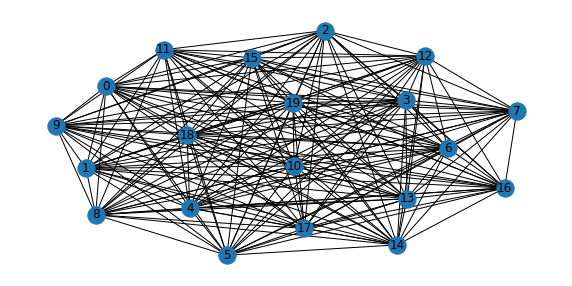

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # pour définir la taille de la figure
nx.draw_networkx(graph)
plt.axis('off')
plt.show()

In [13]:
sma = SMA(nb_agents, matrix)
sma.welfare_type='Egalitarist'
sma.socialWelfare()

sma.run(10)

0 echange  WNJDL  contre  FFQKZ  avec  12
Welfare passe de  109  à  124
1 echange  YNYJG  contre  WNJDL  avec  12
Welfare passe de  124  à  137
2 echange  VYPGP  contre  SWJUQ  avec  6
Welfare passe de  137  à  144
4 echange  XMEHE  contre  FFQKZ  avec  0
Welfare passe de  144  à  154
6 echange  VYPGP  contre  KEILX  avec  11
Welfare passe de  154  à  161
9 echange  LWHIP  contre  VYPGP  avec  11
Welfare passe de  161  à  167
12 echange  YNYJG  contre  GRLQD  avec  19
Welfare passe de  167  à  171
tick 1 ended
Le Welfare actuel est de  171
tick 2 ended
Le Welfare actuel est de  171
tick 3 ended
Le Welfare actuel est de  171
tick 4 ended
Le Welfare actuel est de  171
tick 5 ended
Le Welfare actuel est de  171
tick 6 ended
Le Welfare actuel est de  171
tick 7 ended
Le Welfare actuel est de  171
tick 8 ended
Le Welfare actuel est de  171
tick 9 ended
Le Welfare actuel est de  171
tick 10 ended
Le Welfare actuel est de  171


#### Tracé de l'évolution du social welfare
Une fois l'expérience réalisée, il est alors possible de tracer l'évolution du social Welfare

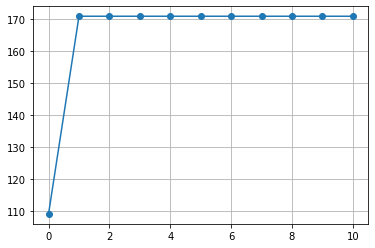

In [17]:
plt.plot(sma.history, "-o")
plt.grid()

Ajouter à SMA 
welfare_type  qui peut etre égal à utilitaire,egalitaire,elitiste,nash et compléter en consequence la procédure socialWelfare dans SMA
history ... qui conserve l'évolution du social welfare
BestWelfare, BestAlloc : qui conservent la meilleure situation (pour tracer les courbes), mis à jour en fin de runOnce

Coder :
Don social : je donne si l'utilité globale augmente (quid si elle ne baisse pas ?)
Don : aucune contrainte sur le don
Swap rationnel : chacun des 2 n'échange que si les deux y gagnent (quid des égalités ?)
Swap social : j'échange avec l'autre uniquement si l'utilité globale augmente (quid si elle ne baisse pas ?)
swap : on échange sans contrainte

Tester différents comportements, différents graphes, différentes valeurs de n et r : n<r <=r n>r

# Bibliographie
- Moulin, H. (2004). Fair division and collective welfare. MIT press.
- Chevaleyre Y, Endriss U, Lang J, Maudet N (2005) Negotiating over small bundles of resources. In: AAMAS’05, pp 296–302
- Nongaillard, A., & Mathieu, P. (2014). Agent-based reallocation problem on social networks. Group Decision and Negotiation, 23(5), 1067-1083.
- Delahaye, J. P., & Mathieu, P. (2009). La répartition idéale des biens existe-t-elle?. Pour la science, 381, 88-93.
